# **MNIST Teacher Student CNN**


En este notebook se creara un red neuronal utilizando la arquitectura de CNN(Convulational Neural Network).

In [1]:
#Run this if you want to force to use CPU
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import numpy as np 
from keras import layers, models
from keras.utils import to_categorical
from keras.datasets import mnist
import matplotlib.pyplot as plt



## Tensorflow + Keras libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2, l1

import tensorflow_model_optimization as tfmot

## Pruning
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

## Quantization
from qkeras import *

## Knowledge Distillation
from src.distillationClassKeras import *

## Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle

## Pre-processing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

## Training
from sklearn.model_selection import train_test_split

2025-12-15 11:36:24.235880: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-15 11:36:24.368508: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-15 11:36:24.369502: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-15 11:36:25.327120: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from tensorflow.keras.optimizers import RMSprop

In [4]:
(train_data, train_labels) , (test_data, test_labels) = mnist.load_data()

In [5]:
train_data.shape 

(60000, 28, 28)

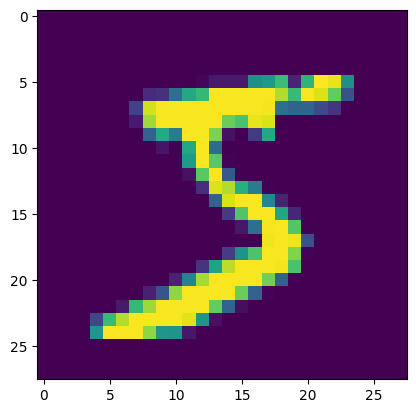

In [6]:
plt.imshow(train_data[0]) #Imagen de ejemplo del MNIST



## Teacher Training

Los hiperparámetros que definen la arquitectura del modelo *Teacher* son:

* Learning rate
* Número de neuronas
* Número de filtros




In [7]:
# Define the hyperparameters for the teacher model
lr = 0.01 #Learning Rate
neurons_teacher = [64, 32] #Numero de neuronas
filters_teacher = [8,16] #Numero de filtros

### Topologia del modelo Teacher

El input esta dado por la forma de la imagen del mnist (28,28,1) y ofrece una salida de 10, que corresponde a los numeros del 0 al 9

In [8]:
def teacher_topology(bestHP_filters, bestHP_neurons):

    # Límite seguro para FPGA/hls4ml
    MAX_FILTERS = 16
    MAX_NEURONS = 128

    f1 = min(bestHP_filters[0], MAX_FILTERS)
    f2 = min(bestHP_filters[1], MAX_FILTERS)

    n1 = min(bestHP_neurons[0], MAX_NEURONS)
    n2 = min(bestHP_neurons[1], MAX_NEURONS)

    teacher = keras.models.Sequential(
        [
            keras.Input(shape=(28, 28, 1)),

            # ---- CNN BLOCK 1 ----
            Conv2D(f1, (3,3), activation='relu', kernel_regularizer=l2(0.001), name='conv1'),
            MaxPooling2D((2,2), name='pool1'),

            # ---- CNN BLOCK 2 ----
            Conv2D(f2, (3,3), activation='relu', kernel_regularizer=l2(0.001), name='conv2'),
            MaxPooling2D((2,2), name='pool2'),

            # ---- FC1 with 1×1 CONV ----
            Conv2D(n1, (1,1), activation='relu', kernel_regularizer=l2(0.001), name='fc1_conv'),

            # Reduce spatial dims to vector
            GlobalAveragePooling2D(name='gap'),

            # ---- FC2 (small dense) ----
            Dense(n2, activation='relu', kernel_regularizer=l2(0.001), name='fc2'),

            Dropout(0.1, name='drop1'),
            Dense(10, activation='softmax', name='output'),
        ],
        name="teacher_CNN",
    )

    teacher.summary()
    return teacher


Para la construccion del modelo teacher, se utiliza el optimizador *Adam* que coge de parametro el learning rate, y utilizamos la funcion de perdidas *categorical_crossentropy* y metricas *accuaracy*

In [9]:
 

def build_teacher(filters_teacher, neurons_teacher):

    model = teacher_topology(filters_teacher, neurons_teacher)
       
    opt = Adam(learning_rate=lr)
    
    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


teacher_model = build_teacher(filters_teacher, neurons_teacher)

Model: "teacher_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 26, 26, 8)         80        
                                                                 
 pool1 (MaxPooling2D)        (None, 13, 13, 8)         0         
                                                                 
 conv2 (Conv2D)              (None, 11, 11, 16)        1168      
                                                                 
 pool2 (MaxPooling2D)        (None, 5, 5, 16)          0         
                                                                 
 fc1_conv (Conv2D)           (None, 5, 5, 64)          1088      
                                                                 
 gap (GlobalAveragePooling2D  (None, 64)               0         
 )                                                               
                                                       

2025-12-15 11:36:29.240611: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-12-15 11:36:29.240640: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: pinpatom
2025-12-15 11:36:29.240653: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: pinpatom
2025-12-15 11:36:29.240764: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 580.82.7
2025-12-15 11:36:29.240791: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 580.82.7
2025-12-15 11:36:29.240799: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 580.82.7


In [10]:
for layer in teacher_model.layers:
    if layer.__class__.__name__ in ['Conv2D', 'Dense']:
        w = layer.get_weights()[0]
        layersize = np.prod(w.shape)
        print("{}: {}".format(layer.name, layersize))  # 0 = weights, 1 = biases
        if layersize > 4096:  # assuming that shape[0] is batch, i.e., 'None'
            print("Layer {} is too large ({}), are you sure you want to train?".format(layer.name, layersize))

conv1: 72
conv2: 1152
fc1_conv: 1024
fc2: 2048
output: 320


In [11]:
# Normalización a float32
x_train = train_data.astype("float32") / 255.0
x_test  = test_data.astype("float32") / 255.0

# Reshape para Conv2D: (N, 28, 28, 1)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test  = x_test.reshape(-1, 28, 28, 1)

# One-hot encoding de las etiquetas
y_train = to_categorical(train_labels, 10)
y_test  = to_categorical(test_labels, 10)

In [12]:
callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=12, verbose=1, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.4, patience=3, verbose=1)
            ] 

history_teacher  = teacher_model.fit(x=x_train, y=y_train,
                  validation_data=(x_test, y_test), 
                  batch_size = 64,
                  epochs=32,
                  callbacks = [callbacks],
                  verbose=1
                  )   

Epoch 1/32


2025-12-15 11:36:29.933276: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


935/938 [============================>.] - ETA: 0s - loss: 1.4725 - accuracy: 0.4556

2025-12-15 11:36:39.547937: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


938/938 [==============================] - 10s 10ms/step - loss: 1.4714 - accuracy: 0.4563 - val_loss: 1.0084 - val_accuracy: 0.6753 - lr: 0.0100
Epoch 2/32
938/938 [==============================] - 10s 11ms/step - loss: 0.8327 - accuracy: 0.7615 - val_loss: 0.6166 - val_accuracy: 0.8392 - lr: 0.0100
Epoch 3/32
938/938 [==============================] - 11s 12ms/step - loss: 0.6289 - accuracy: 0.8464 - val_loss: 0.4486 - val_accuracy: 0.9126 - lr: 0.0100
Epoch 4/32
938/938 [==============================] - 10s 10ms/step - loss: 0.5363 - accuracy: 0.8854 - val_loss: 0.4145 - val_accuracy: 0.9270 - lr: 0.0100
Epoch 5/32
938/938 [==============================] - 10s 10ms/step - loss: 0.4681 - accuracy: 0.9064 - val_loss: 0.3928 - val_accuracy: 0.9313 - lr: 0.0100
Epoch 6/32
938/938 [==============================] - 9s 10ms/step - loss: 0.4423 - accuracy: 0.9138 - val_loss: 0.3574 - val_accuracy: 0.9391 - lr: 0.0100
Epoch 7/32
938/938 [==============================] - 10s 11ms/step - 

### **Conceptos clave**

En aprendizaje automático, la *accuracy* (precisión) mide qué proporción de predicciones son correctas. Durante el entrenamiento se suelen mostrar dos curvas: la precisión sobre los datos de **entrenamiento**, que indica qué tan bien el modelo aprende de los ejemplos que ya ha visto, y la precisión de **validación**, que muestra qué tan bien generaliza a datos nuevos que no vio durante el entrenamiento. Si ambas curvas suben y se mantienen cercanas, significa que el modelo está aprendiendo correctamente y no está memorizando los datos (sobreajuste). Por otro lado, si la precisión de entrenamiento sube mientras la de validación baja o se estanca, puede indicar problemas de *overfitting*.




dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


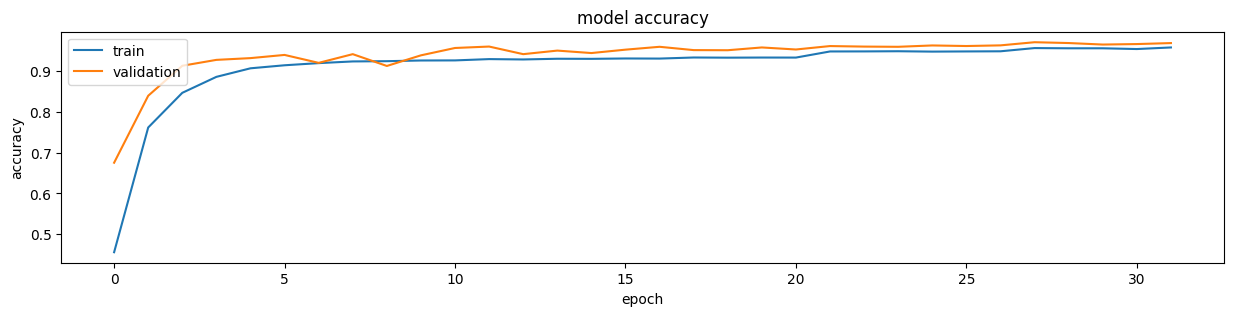

<Figure size 640x480 with 0 Axes>

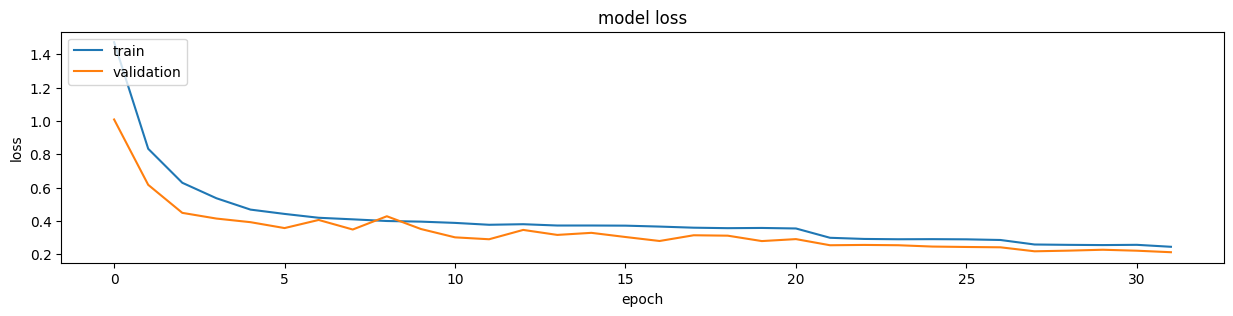

In [13]:
print(history_teacher.history.keys())

## Plot for accuracy
plt.figure(figsize=(15,3))
plt.plot(history_teacher.history['accuracy'])
plt.plot(history_teacher.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.figure()

## Plot for loss
plt.figure(figsize=(15,3))
plt.plot(history_teacher.history['loss'])
plt.plot(history_teacher.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

En las gráficas mostradas se observa que tanto la precisión de entrenamiento como la de validación aumentan de forma rápida al inicio y luego se estabilizan alrededor del 99%, manteniéndose muy cercanas entre sí. Esto sugiere que el modelo ha aprendido de manera adecuada el conjunto MNIST y logra generalizar bien a los datos nuevos. No hay evidencia de sobreajuste importante, ya que ambas curvas siguen trayectorias similares y se mantienen estables. En conjunto, las métricas indican que el modelo alcanza un desempeño excelente y un entrenamiento equilibrado.

### **Qué es una matriz de confusión**

Una matriz de confusión es una herramienta que permite evaluar el rendimiento de un modelo de clasificación mostrando cuántos ejemplos fueron predichos correctamente y cuántos fueron confundidos con otras clases. Cada fila representa la **etiqueta verdadera**, mientras que cada columna representa la **predicción del modelo**. Los valores en la diagonal indican aciertos: cuantos más valores altos haya allí, mejor es el rendimiento. Los valores fuera de la diagonal indican errores y muestran específicamente qué clases se confunden entre sí, lo que ayuda a identificar patrones de fallo del modelo.



 20/313 [>.............................] - ETA: 0s 

2025-12-15 11:41:32.926807: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


313/313 [==============================] - 1s 3ms/step


<Figure size 700x700 with 0 Axes>

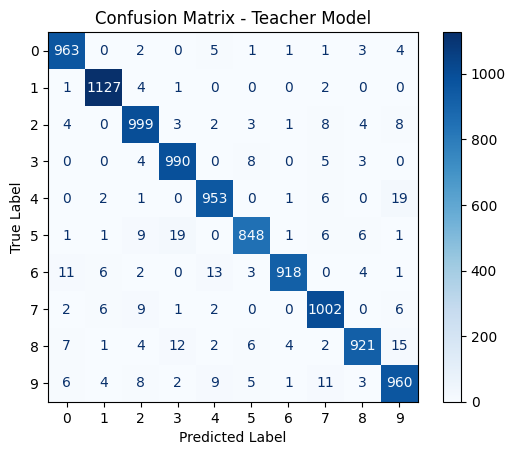

In [14]:
# 1. Predecir probabilidades
y_pred_probs = teacher_model.predict(x_test)   # usa x_test de MNIST

# 2. Convertir a etiquetas predichas
y_pred = np.argmax(y_pred_probs, axis=1)

# 3. Convertir y_test one-hot a etiquetas reales
y_true = np.argmax(y_test, axis=1)

# 4. Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# 5. Plot limpio
plt.figure(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - Teacher Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


La matriz de confusión del *Teacher Model* indica un rendimiento excelente: la diagonal contiene valores muy altos, lo que significa que casi todas las imágenes de cada dígito fueron clasificadas correctamente. Los errores son pocos y dispersos, típicamente confusiones muy comunes en MNIST, como algunos “5” predichos como “3” o algunos “8” confundidos con “9”. Las clases con más precisión incluyen los dígitos 1, 7 y 9, que muestran muy pocos errores. En general, los resultados reflejan un modelo robusto y altamente preciso, con un comportamiento consistente con modelos bien entrenados en MNIST.


In [15]:
teacher_model.save('models/CNN/teacherModelMnistCNN.h5')

# **Pruning**


El pruning es una técnica utilizada para reducir el tamaño y la complejidad de un modelo de deep learning mediante la eliminación de pesos o neuronas que se consideran poco relevantes. El objetivo principal es mejorar la eficiencia del modelo reduciendo el consumo de memoria y acelerando la inferencia, todo ello sin afectar de manera significativa la precisión final del modelo.



In [16]:
epochs = 16
lr = 0.001
loss = 'categorical_crossentropy'
op = Adam(lr)
metrics = ['accuracy']
batch = 32
val_split = 0.2

final_sparsity = 0.5

pruning_params = {
                'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
                initial_sparsity=0, final_sparsity=final_sparsity, begin_step=0, end_step=1000
                )
            }

callbacks.append(pruning_callbacks.UpdatePruningStep())

In [17]:
modelP = tfmot.sparsity.keras.prune_low_magnitude(teacher_model, **pruning_params)

modelP.compile(optimizer=op, loss=loss, metrics=metrics)

In [18]:
history_P  = modelP.fit(x=x_train, y=y_train,
                  validation_split = val_split,
                  batch_size = 64,
                  epochs=32,
                  callbacks = [callbacks],
                  verbose=1
                  )   

Epoch 1/32


2025-12-15 11:41:35.357452: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150528000 exceeds 10% of free system memory.


750/750 [==============================] - ETA: 0s - loss: 0.2565 - accuracy: 0.9540

2025-12-15 11:41:48.339239: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 37632000 exceeds 10% of free system memory.


750/750 [==============================] - 14s 13ms/step - loss: 0.2565 - accuracy: 0.9540 - val_loss: 0.2156 - val_accuracy: 0.9653 - lr: 0.0010
Epoch 2/32
750/750 [==============================] - 8s 11ms/step - loss: 0.2550 - accuracy: 0.9541 - val_loss: 0.2170 - val_accuracy: 0.9660 - lr: 0.0010
Epoch 3/32
750/750 [==============================] - 8s 10ms/step - loss: 0.2504 - accuracy: 0.9561 - val_loss: 0.2059 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 4/32
750/750 [==============================] - 9s 12ms/step - loss: 0.2490 - accuracy: 0.9563 - val_loss: 0.2139 - val_accuracy: 0.9656 - lr: 0.0010
Epoch 5/32
750/750 [==============================] - 9s 12ms/step - loss: 0.2481 - accuracy: 0.9569 - val_loss: 0.2076 - val_accuracy: 0.9684 - lr: 0.0010
Epoch 6/32
750/750 [==============================] - 8s 11ms/step - loss: 0.2467 - accuracy: 0.9560 - val_loss: 0.2055 - val_accuracy: 0.9680 - lr: 0.0010
Epoch 7/32
750/750 [==============================] - 9s 12ms/step - loss:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


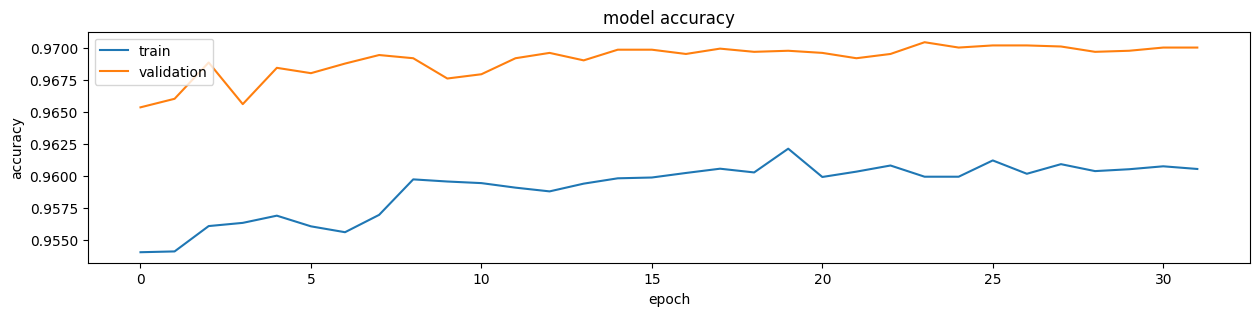

<Figure size 640x480 with 0 Axes>

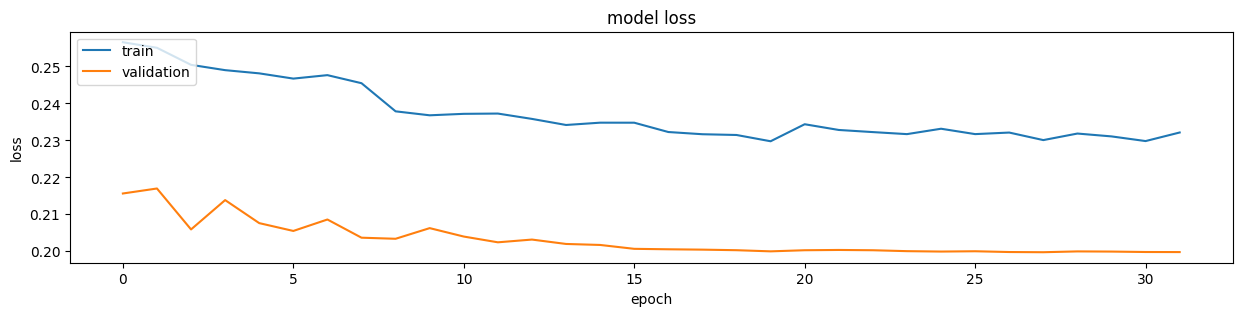

In [19]:
print(history_P.history.keys())

## Plot for accuracy
plt.figure(figsize=(15,3))
plt.plot(history_P.history['accuracy'])
plt.plot(history_P.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.figure()

## Plot for loss
plt.figure(figsize=(15,3))
plt.plot(history_P.history['loss'])
plt.plot(history_P.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

313/313 [==============================] - 2s 5ms/step


<Figure size 700x700 with 0 Axes>

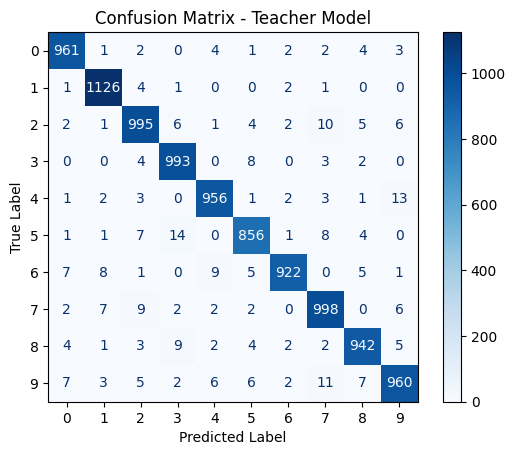

In [20]:
# 1. Predecir probabilidades
y_pred_probs =modelP.predict(x_test)   # usa x_test de MNIST

# 2. Convertir a etiquetas predichas
y_pred = np.argmax(y_pred_probs, axis=1)

# 3. Convertir y_test one-hot a etiquetas reales
y_true = np.argmax(y_test, axis=1)

# 4. Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# 5. Plot limpio
plt.figure(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - Teacher Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [21]:
modelP.save('models/CNN/teacherModelMnistCNN_pruned.h5')

### **Quantization**


Es una técnica que reduce la precisión numérica de los parámetros de una red neuronal al convertir valores en punto flotante de **32 bits** a representaciones más pequeñas, como **16 bits** o incluso **8 bits**. El objetivo es disminuir el tamaño del modelo, mejorar la velocidad de inferencia y permitir que funcione en dispositivos con recursos limitados.

Para este caso se utilizan **quantization-aware training** (QAT) y **quantization-aware pruning** (QAP):

* **QAT** es una técnica en la que el modelo aprende a adaptarse a la cuantización durante el entrenamiento. En lugar de entrenar el modelo por completo y cuantificarlo al final, la cuantización se introduce desde el proceso de entrenamiento para que el modelo aprenda a trabajar bajo esa restricción numérica.

* **QAP** combina el *pruning* con QAT. La idea es reducir el modelo a través de poda antes de cuantificarlo, logrando una red más eficiente en tamaño y velocidad sin sacrificar la precisión.




In [22]:
# Estrategia de cuantización – 6 bits
kernelQ = "quantized_bits(6,0,alpha=1)"
biasQ   = "quantized_bits(6,0,alpha=1)"
activationQ = "quantized_relu(6)"

# Hiperparámetros EDITABLES (limitados para FPGA)
MAX_FILTERS = 32
MAX_NEURONS = 128

f1 = min(filters_teacher[0], MAX_FILTERS)
f2 = min(filters_teacher[1], MAX_FILTERS)

n1 = min(neurons_teacher[0], MAX_NEURONS)
n2 = min(neurons_teacher[1], MAX_NEURONS)

# ---------------------------------------
# MODELO QAT OPTIMIZADO PARA FPGA
# ---------------------------------------
modelQAT = Sequential(
    [

        keras.Input(shape=(28, 28, 1)),

        # ----------- CONV 1 -----------
        QConv2D(
            f1,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="valid",
            kernel_quantizer=kernelQ,
            bias_quantizer=biasQ,
            kernel_initializer="lecun_uniform",
            name="conv1",
        ),
        QActivation(activation=activationQ, name="conv1_act"),
        MaxPooling2D(pool_size=(2, 2), name="pool1"),

        # ----------- CONV 2 -----------
        QConv2D(
            f2,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="valid",
            kernel_quantizer=kernelQ,
            bias_quantizer=biasQ,
            kernel_initializer="lecun_uniform",
            name="conv2",
        ),
        QActivation(activation=activationQ, name="conv2_act"),
        MaxPooling2D(pool_size=(2, 2), name="pool2"),

        # ----------- FC1 (1×1 CONV) -----------
        QConv2D(
            n1,
            kernel_size=(1, 1),
            padding="valid",
            kernel_quantizer=kernelQ,
            bias_quantizer=biasQ,
            kernel_initializer="lecun_uniform",
            name="fc1_conv",
        ),
        QActivation(activation=activationQ, name="fc1_conv_act"),

        # ----------- GLOBAL AVERAGE POOLING -----------
        GlobalAveragePooling2D(name="gap"),

        # ----------- FC2 -----------
        QDense(
            n2,
            name="fc2",
            kernel_quantizer=kernelQ,
            bias_quantizer=biasQ,
            kernel_initializer="lecun_uniform",
        ),
        QActivation(activation=activationQ, name="relu2"),

        # ----------- DROPOUT -----------
        Dropout(0.1, name="drop1"),

        # ----------- OUTPUT -----------
        QDense(
            10,
            name="output",
            kernel_quantizer=kernelQ,
            bias_quantizer=biasQ,
            kernel_initializer="lecun_uniform",
        ),
        QActivation("softmax", name="softmax"),
    ],
    name="quantized_teacher_CNN_MLP",
)

modelQAT.summary()


Model: "quantized_teacher_CNN_MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (QConv2D)             (None, 26, 26, 8)         80        
                                                                 
 conv1_act (QActivation)     (None, 26, 26, 8)         0         
                                                                 
 pool1 (MaxPooling2D)        (None, 13, 13, 8)         0         
                                                                 
 conv2 (QConv2D)             (None, 11, 11, 16)        1168      
                                                                 
 conv2_act (QActivation)     (None, 11, 11, 16)        0         
                                                                 
 pool2 (MaxPooling2D)        (None, 5, 5, 16)          0         
                                                                 
 fc1_conv (QConv2D)          (None, 5, 5,

In [23]:
for layer in modelQAT.layers:
    if layer.__class__.__name__ in ['QConv2D', 'QDense']:
        w = layer.get_weights()[0]
        layersize = np.prod(w.shape)
        print("{}: {}".format(layer.name, layersize))  # 0 = weights, 1 = biases
        if layersize > 4096:  # assuming that shape[0] is batch, i.e., 'None'
            print("Layer {} is too large ({}), are you sure you want to train?".format(layer.name, layersize))

conv1: 72
conv2: 1152
fc1_conv: 1024
fc2: 2048
output: 320


In [24]:
# Model Training

epochs = 16
lr = 0.001
loss = 'categorical_crossentropy'
op = Adam(lr)
metrics = ['accuracy']
batch = 32
val_split = 0.2


modelQAT.compile(optimizer=op, loss=loss, metrics=metrics)
                
historyQAT = modelQAT.fit(x=x_train, y=y_train,
                validation_split = val_split,
                epochs=epochs,
                batch_size = batch,
                verbose=1
                )

Epoch 1/16
1500/1500 [==============================] - 30s 18ms/step - loss: 1.3832 - accuracy: 0.5362 - val_loss: 0.8325 - val_accuracy: 0.7477
Epoch 2/16
1500/1500 [==============================] - 22s 15ms/step - loss: 0.7502 - accuracy: 0.7656 - val_loss: 0.6429 - val_accuracy: 0.8032
Epoch 3/16
1500/1500 [==============================] - 20s 13ms/step - loss: 0.5763 - accuracy: 0.8290 - val_loss: 0.4443 - val_accuracy: 0.8810
Epoch 4/16
1500/1500 [==============================] - 20s 13ms/step - loss: 0.4787 - accuracy: 0.8619 - val_loss: 0.3700 - val_accuracy: 0.9014
Epoch 5/16
1500/1500 [==============================] - 22s 15ms/step - loss: 0.4137 - accuracy: 0.8813 - val_loss: 0.3479 - val_accuracy: 0.9046
Epoch 6/16
1500/1500 [==============================] - 21s 14ms/step - loss: 0.3730 - accuracy: 0.8932 - val_loss: 0.2846 - val_accuracy: 0.9237
Epoch 7/16
1500/1500 [==============================] - 22s 15ms/step - loss: 0.3371 - accuracy: 0.9038 - val_loss: 0.2633 -

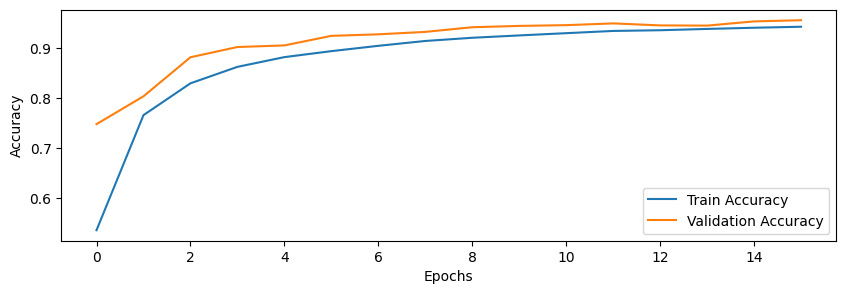

In [25]:
# Plot accuracy over epochs
plt.figure(figsize=(10,3))
plt.plot(historyQAT.history['accuracy'], label='Train Accuracy')
plt.plot(historyQAT.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

313/313 [==============================] - 3s 6ms/step


<Figure size 700x700 with 0 Axes>

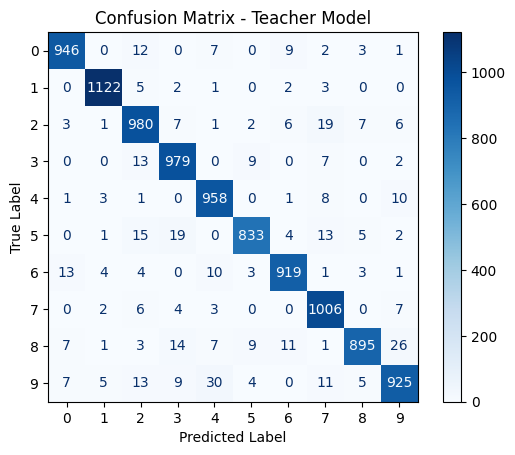

In [26]:
# 1. Predecir probabilidades
y_pred_probs =modelQAT.predict(x_test)   # usa x_test de MNIST

# 2. Convertir a etiquetas predichas
y_pred = np.argmax(y_pred_probs, axis=1)

# 3. Convertir y_test one-hot a etiquetas reales
y_true = np.argmax(y_test, axis=1)

# 4. Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# 5. Plot limpio
plt.figure(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - Teacher Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [27]:
modelQAT.save('models/CNN/teacherModelQATMnistCNN.h5')

# **Student network** 

Para implementar un modelo de red neuronal en una FPGA, se reduce el tamaño del modelo *Teacher* creando un modelo *Student* mediante **Knowledge Distillation (KD)**. Este método consiste en transferir el conocimiento del modelo *Teacher* al *Student*, permitiendo que el modelo más pequeño mantenga un rendimiento similar al del modelo original.


In [28]:
lr = 0.01
neurons_student = [50,28]
filters_student = [8,16]

In [29]:
def student_topology(neurons_student):

    '''
    Compact model for knowledge distillation (Student).
    Uses quantization-aware training + FPGA-friendly topology.
    '''

    # -----------------------------
    # Cuantización
    # -----------------------------

    # 4-bits
    kernelQ_4b = "quantized_bits(4,2,alpha=1)"
    biasQ_4b   = "quantized_bits(4,2,alpha=1)"
    activationQ_4b = "quantized_bits(4,0)"

    kernelQ = "quantized_bits(6,0,alpha=1)"
    biasQ   = "quantized_bits(6,0,alpha=1)"
    activationQ = "quantized_relu(6)"

    # 8-bits (principal)
    kernelQ_8b = "quantized_bits(8,4,alpha=1)"
    biasQ_8b   = "quantized_bits(8,4,alpha=1)"
    activationQ_8b = "quantized_bits(8)"

    # 16-bits (salida)
    kernelQ_16b = "quantized_bits(16,6,alpha=1)"
    biasQ_16b   = "quantized_bits(16,6,alpha=1)"
    activationQ_16b = "quantized_bits(16)"

    # -----------------------------
    # Limites de hardware
    # -----------------------------
    MAX_FILTERS = 32
    MAX_NEURONS = 128

    # Filtros CNN (versión student más pequeña)
    f1 = min(8, MAX_FILTERS)
    f2 = min(16, MAX_FILTERS)

    # Neuronas densas
    n1 = min(neurons_student[0], MAX_NEURONS)
    n2 = min(neurons_student[1], MAX_NEURONS)

    # -----------------------------
    # MODELO STUDENT QAT (CNN + 1×1 CONV + GAP)
    # -----------------------------
    studentQ_CNN_MLP = Sequential(
        [
            Input(shape=(28, 28, 1), name="inputLayer"),

            # ----------- CONV 1 -----------
            QConv2D(
                f1,
                (3, 3),
                padding="valid",
                kernel_quantizer=kernelQ,
                bias_quantizer=biasQ,
                kernel_initializer="lecun_uniform",
                name="conv1",
            ),
            QActivation(activation=activationQ, name="conv1_act"),
            MaxPooling2D(pool_size=(2, 2), name="pool1"),

            # ----------- CONV 2 -----------
            QConv2D(
                f2,
                (3, 3),
                padding="valid",
                kernel_quantizer=kernelQ,
                bias_quantizer=biasQ,
                kernel_initializer="lecun_uniform",
                name="conv2",
            ),
            QActivation(activation=activationQ, name="conv2_act"),
            MaxPooling2D(pool_size=(2, 2), name="pool2"),

            # ----------- FC1 (1×1 CONV) -----------
            QConv2D(
                n1,
                kernel_size=(1, 1),
                padding="valid",
                kernel_quantizer=kernelQ,
                bias_quantizer=biasQ,
                kernel_initializer="lecun_uniform",
                name="fc1_conv",
            ),
            QActivation(activation=activationQ, name="fc1_conv_act"),

            # ----------- GLOBAL AVERAGE POOLING -----------
            GlobalAveragePooling2D(name="gap"),

            # ----------- FC2 PEQUEÑA -----------
            QDense(
                n2,
                kernel_quantizer=kernelQ,
                bias_quantizer=biasQ,
                kernel_initializer="lecun_uniform",
                name="fc2",
            ),
            QActivation(activation=activationQ, name="relu2"),

            Dropout(0.1, name="drop1"),

            # ----------- OUTPUT -----------
            QDense(
                10,
                kernel_quantizer=kernelQ_16b,
                bias_quantizer=biasQ_16b,
                kernel_initializer="lecun_uniform",
                name="output",
            ),
            Activation("softmax", name="outputActivation"),
        ],
        name="studentQ_CNN_MLP",
    )

    studentQ_CNN_MLP.summary()
    return studentQ_CNN_MLP


In [30]:
def build_student(student_neurons):

    '''
    Model to be compressed. Defined with quantization strategies. 
    Input: hyperparams (student_neurons).
    Output: compressed model (studentQ). 

    '''
    
    qmodel = student_topology(student_neurons)

    # Pruning parameters 
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.0, final_sparsity=0.5, begin_step=0, end_step=1000
    )
    }
    
    studentQ = prune.prune_low_magnitude(qmodel, **pruning_params)
    
    
    return studentQ

In [31]:
studentQ = build_student(neurons_student)

distilled_student = Distiller(student=studentQ, teacher=teacher_model)

adam = Adam(lr)

train_labels = np.argmax(y_train, axis=1)

distilled_student.compile(
        optimizer=adam,
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
        student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        distillation_loss_fn=keras.losses.KLDivergence(),
        alpha=0.1, 
        temperature=10,
    )

Model: "studentQ_CNN_MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (QConv2D)             (None, 26, 26, 8)         80        
                                                                 
 conv1_act (QActivation)     (None, 26, 26, 8)         0         
                                                                 
 pool1 (MaxPooling2D)        (None, 13, 13, 8)         0         
                                                                 
 conv2 (QConv2D)             (None, 11, 11, 16)        1168      
                                                                 
 conv2_act (QActivation)     (None, 11, 11, 16)        0         
                                                                 
 pool2 (MaxPooling2D)        (None, 5, 5, 16)          0         
                                                                 
 fc1_conv (QConv2D)          (None, 5, 5, 50)     

In [32]:
callbacks = [
                tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
                tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.3, patience=3, verbose=1),
                ]  

callbacks.append(pruning_callbacks.UpdatePruningStep())

history_studentQPKD = distilled_student.fit(x_train, train_labels, 
                               batch_size = 64, 
                               epochs= 32, 
                               validation_split=0.2,
                               callbacks = callbacks
                               )

Epoch 1/32


/home/pinpa/anaconda3/envs/mf_env/lib/python3.11/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


749/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.6863 - student_loss: 0.9234 - distillation_loss: 1.9621e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 23s 23ms/step - sparse_categorical_accuracy: 0.6865 - student_loss: 0.9226 - distillation_loss: 1.9600e-04 - val_sparse_categorical_accuracy: 0.8584 - val_student_loss: 0.2826 - lr: 0.0100
Epoch 2/32
749/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8246 - student_loss: 0.5373 - distillation_loss: 1.0864e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 16s 22ms/step - sparse_categorical_accuracy: 0.8246 - student_loss: 0.5372 - distillation_loss: 1.0863e-04 - val_sparse_categorical_accuracy: 0.8869 - val_student_loss: 0.2345 - lr: 0.0100
Epoch 3/32
750/750 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.8489 - student_loss: 0.4713 - distillation_loss: 9.2808e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 15s 20ms/step - sparse_categorical_accuracy: 0.8489 - student_loss: 0.4712 - distillation_loss: 9.2799e-05 - val_sparse_categorical_accuracy: 0.9071 - val_student_loss: 0.2073 - lr: 0.0100
Epoch 4/32
749/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8683 - student_loss: 0.4125 - distillation_loss: 7.9228e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 15s 20ms/step - sparse_categorical_accuracy: 0.8683 - student_loss: 0.4124 - distillation_loss: 7.9249e-05 - val_sparse_categorical_accuracy: 0.9024 - val_student_loss: 0.1850 - lr: 0.0100
Epoch 5/32
749/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8788 - student_loss: 0.3869 - distillation_loss: 7.3125e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 17s 22ms/step - sparse_categorical_accuracy: 0.8788 - student_loss: 0.3871 - distillation_loss: 7.3072e-05 - val_sparse_categorical_accuracy: 0.8972 - val_student_loss: 0.1860 - lr: 0.0100
Epoch 6/32
748/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8837 - student_loss: 0.3672 - distillation_loss: 6.8276e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 19s 26ms/step - sparse_categorical_accuracy: 0.8839 - student_loss: 0.3666 - distillation_loss: 6.8145e-05 - val_sparse_categorical_accuracy: 0.9256 - val_student_loss: 0.1250 - lr: 0.0100
Epoch 7/32
748/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8887 - student_loss: 0.3525 - distillation_loss: 6.5071e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 17s 23ms/step - sparse_categorical_accuracy: 0.8887 - student_loss: 0.3526 - distillation_loss: 6.5107e-05 - val_sparse_categorical_accuracy: 0.9208 - val_student_loss: 0.1098 - lr: 0.0100
Epoch 8/32
749/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8947 - student_loss: 0.3400 - distillation_loss: 6.1740e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 16s 21ms/step - sparse_categorical_accuracy: 0.8947 - student_loss: 0.3398 - distillation_loss: 6.1677e-05 - val_sparse_categorical_accuracy: 0.9302 - val_student_loss: 0.2318 - lr: 0.0100
Epoch 9/32
749/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8968 - student_loss: 0.3344 - distillation_loss: 6.0436e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 19s 25ms/step - sparse_categorical_accuracy: 0.8968 - student_loss: 0.3347 - distillation_loss: 6.0465e-05 - val_sparse_categorical_accuracy: 0.9232 - val_student_loss: 0.1250 - lr: 0.0100
Epoch 10/32
750/750 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.8988 - student_loss: 0.3263 - distillation_loss: 5.8601e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 19s 25ms/step - sparse_categorical_accuracy: 0.8988 - student_loss: 0.3261 - distillation_loss: 5.8576e-05 - val_sparse_categorical_accuracy: 0.9172 - val_student_loss: 0.1334 - lr: 0.0100
Epoch 11/32
748/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.9013 - student_loss: 0.3188 - distillation_loss: 5.7796e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 17s 23ms/step - sparse_categorical_accuracy: 0.9014 - student_loss: 0.3183 - distillation_loss: 5.7707e-05 - val_sparse_categorical_accuracy: 0.9323 - val_student_loss: 0.1684 - lr: 0.0100
Epoch 12/32
750/750 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.9024 - student_loss: 0.3183 - distillation_loss: 5.6961e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 17s 22ms/step - sparse_categorical_accuracy: 0.9024 - student_loss: 0.3185 - distillation_loss: 5.6968e-05 - val_sparse_categorical_accuracy: 0.9408 - val_student_loss: 0.1742 - lr: 0.0100
Epoch 13/32
748/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.9029 - student_loss: 0.3164 - distillation_loss: 5.7068e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 17s 22ms/step - sparse_categorical_accuracy: 0.9029 - student_loss: 0.3165 - distillation_loss: 5.7124e-05 - val_sparse_categorical_accuracy: 0.9423 - val_student_loss: 0.1404 - lr: 0.0100
Epoch 14/32
748/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.9032 - student_loss: 0.3100 - distillation_loss: 5.5774e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 16s 21ms/step - sparse_categorical_accuracy: 0.9033 - student_loss: 0.3095 - distillation_loss: 5.5717e-05 - val_sparse_categorical_accuracy: 0.9434 - val_student_loss: 0.0807 - lr: 0.0100
Epoch 15/32
750/750 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.9057 - student_loss: 0.3061 - distillation_loss: 5.4864e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 17s 22ms/step - sparse_categorical_accuracy: 0.9057 - student_loss: 0.3061 - distillation_loss: 5.4866e-05 - val_sparse_categorical_accuracy: 0.9384 - val_student_loss: 0.1553 - lr: 0.0100
Epoch 16/32
748/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.9083 - student_loss: 0.2960 - distillation_loss: 5.2238e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 17s 22ms/step - sparse_categorical_accuracy: 0.9082 - student_loss: 0.2962 - distillation_loss: 5.2304e-05 - val_sparse_categorical_accuracy: 0.9425 - val_student_loss: 0.0919 - lr: 0.0100
Epoch 17/32
750/750 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.9067 - student_loss: 0.3020 - distillation_loss: 5.3685e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 16s 22ms/step - sparse_categorical_accuracy: 0.9067 - student_loss: 0.3020 - distillation_loss: 5.3676e-05 - val_sparse_categorical_accuracy: 0.9443 - val_student_loss: 0.0884 - lr: 0.0100
Epoch 18/32
748/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.9081 - student_loss: 0.2973 - distillation_loss: 5.2529e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 16s 22ms/step - sparse_categorical_accuracy: 0.9081 - student_loss: 0.2967 - distillation_loss: 5.2443e-05 - val_sparse_categorical_accuracy: 0.9156 - val_student_loss: 0.1219 - lr: 0.0100
Epoch 19/32
749/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.9091 - student_loss: 0.2984 - distillation_loss: 5.2838e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 17s 23ms/step - sparse_categorical_accuracy: 0.9091 - student_loss: 0.2984 - distillation_loss: 5.2824e-05 - val_sparse_categorical_accuracy: 0.9296 - val_student_loss: 0.1383 - lr: 0.0100
Epoch 20/32
750/750 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.9091 - student_loss: 0.2928 - distillation_loss: 5.1930e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 19s 25ms/step - sparse_categorical_accuracy: 0.9091 - student_loss: 0.2926 - distillation_loss: 5.1896e-05 - val_sparse_categorical_accuracy: 0.9308 - val_student_loss: 0.1742 - lr: 0.0100
Epoch 21/32
749/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.9106 - student_loss: 0.2892 - distillation_loss: 5.1237e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 18s 24ms/step - sparse_categorical_accuracy: 0.9107 - student_loss: 0.2890 - distillation_loss: 5.1166e-05 - val_sparse_categorical_accuracy: 0.9341 - val_student_loss: 0.0724 - lr: 0.0100
Epoch 22/32
749/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.9074 - student_loss: 0.2972 - distillation_loss: 5.2916e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 21s 28ms/step - sparse_categorical_accuracy: 0.9075 - student_loss: 0.2968 - distillation_loss: 5.2838e-05 - val_sparse_categorical_accuracy: 0.9440 - val_student_loss: 0.0659 - lr: 0.0100
Epoch 23/32
748/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.9101 - student_loss: 0.2891 - distillation_loss: 5.1417e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 20s 26ms/step - sparse_categorical_accuracy: 0.9100 - student_loss: 0.2895 - distillation_loss: 5.1437e-05 - val_sparse_categorical_accuracy: 0.9274 - val_student_loss: 0.1083 - lr: 0.0100
Epoch 24/32
750/750 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.9105 - student_loss: 0.2901 - distillation_loss: 5.1826e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 23s 31ms/step - sparse_categorical_accuracy: 0.9105 - student_loss: 0.2902 - distillation_loss: 5.1818e-05 - val_sparse_categorical_accuracy: 0.9329 - val_student_loss: 0.0725 - lr: 0.0100
Epoch 25/32
750/750 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.9113 - student_loss: 0.2893 - distillation_loss: 5.1451e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 20s 26ms/step - sparse_categorical_accuracy: 0.9113 - student_loss: 0.2891 - distillation_loss: 5.1397e-05 - val_sparse_categorical_accuracy: 0.9274 - val_student_loss: 0.1077 - lr: 0.0100
Epoch 26/32
748/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.9107 - student_loss: 0.2836 - distillation_loss: 5.1009e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 18s 24ms/step - sparse_categorical_accuracy: 0.9107 - student_loss: 0.2835 - distillation_loss: 5.0979e-05 - val_sparse_categorical_accuracy: 0.9445 - val_student_loss: 0.0639 - lr: 0.0100
Epoch 27/32
748/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.9112 - student_loss: 0.2847 - distillation_loss: 5.0260e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 18s 24ms/step - sparse_categorical_accuracy: 0.9113 - student_loss: 0.2847 - distillation_loss: 5.0252e-05 - val_sparse_categorical_accuracy: 0.9294 - val_student_loss: 0.1497 - lr: 0.0100
Epoch 28/32
748/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.9132 - student_loss: 0.2799 - distillation_loss: 4.9170e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 18s 24ms/step - sparse_categorical_accuracy: 0.9131 - student_loss: 0.2801 - distillation_loss: 4.9227e-05 - val_sparse_categorical_accuracy: 0.9315 - val_student_loss: 0.1716 - lr: 0.0100
Epoch 29/32
748/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.9129 - student_loss: 0.2844 - distillation_loss: 5.0980e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 18s 23ms/step - sparse_categorical_accuracy: 0.9129 - student_loss: 0.2842 - distillation_loss: 5.0970e-05 - val_sparse_categorical_accuracy: 0.9283 - val_student_loss: 0.0671 - lr: 0.0100
Epoch 30/32
749/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.9114 - student_loss: 0.2862 - distillation_loss: 5.1257e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 17s 23ms/step - sparse_categorical_accuracy: 0.9114 - student_loss: 0.2860 - distillation_loss: 5.1225e-05 - val_sparse_categorical_accuracy: 0.9346 - val_student_loss: 0.0807 - lr: 0.0100
Epoch 31/32
750/750 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.9128 - student_loss: 0.2832 - distillation_loss: 5.0860e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 17s 23ms/step - sparse_categorical_accuracy: 0.9128 - student_loss: 0.2831 - distillation_loss: 5.0830e-05 - val_sparse_categorical_accuracy: 0.9429 - val_student_loss: 0.0892 - lr: 0.0100
Epoch 32/32
750/750 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.9125 - student_loss: 0.2795 - distillation_loss: 4.9665e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 20s 26ms/step - sparse_categorical_accuracy: 0.9125 - student_loss: 0.2795 - distillation_loss: 4.9676e-05 - val_sparse_categorical_accuracy: 0.9388 - val_student_loss: 0.0691 - lr: 0.0100


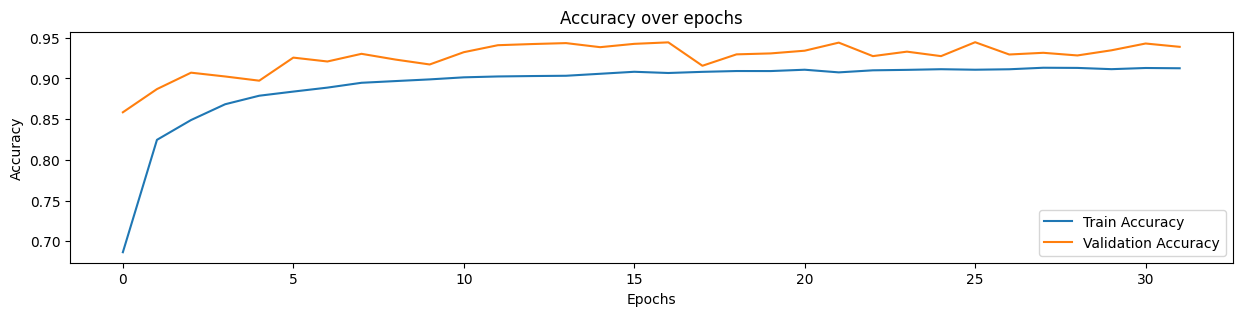

In [33]:
# Plot accuracy over epochs
plt.figure(figsize=(15,3))
plt.plot(history_studentQPKD.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history_studentQPKD.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

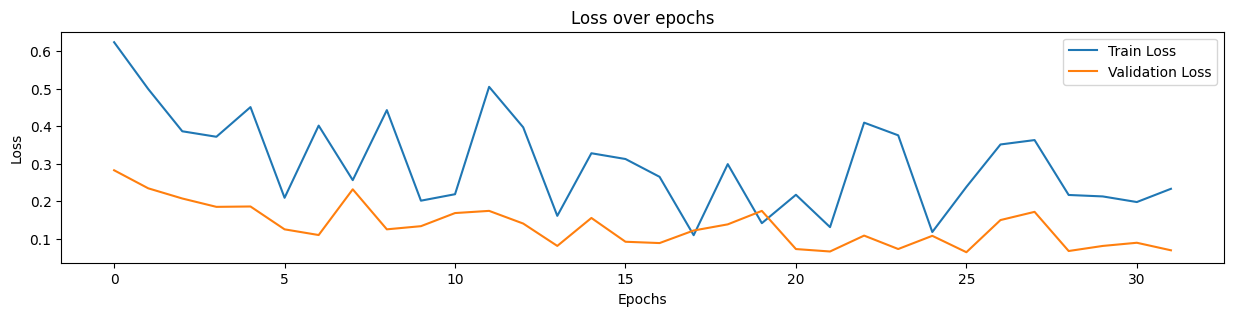

In [34]:
# Plot loss over epochs
plt.figure(figsize=(15,3))
plt.plot(history_studentQPKD.history['student_loss'], label='Train Loss')
plt.plot(history_studentQPKD.history['val_student_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()

313/313 [==============================] - 3s 6ms/step


<Figure size 700x700 with 0 Axes>

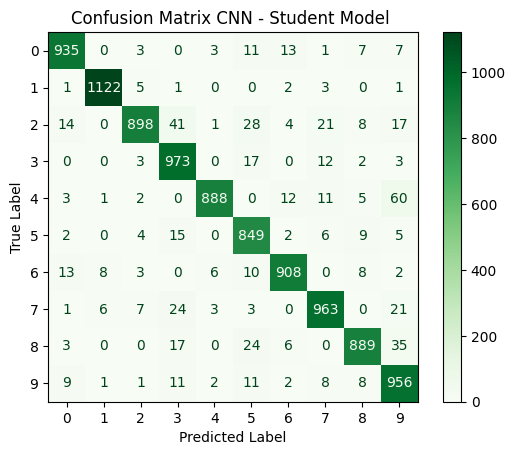

In [35]:
# 1. Predecir probabilidades
y_pred_probs =distilled_student.student.predict(x_test)   # usa x_test de MNIST

# 2. Convertir a etiquetas predichas
y_pred = np.argmax(y_pred_probs, axis=1)

# 3. Convertir y_test one-hot a etiquetas reales
y_true = np.argmax(y_test, axis=1)

# 4. Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# 5. Plot limpio
plt.figure(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Greens", values_format='d')
plt.title("Confusion Matrix CNN - Student Model ")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [36]:
student_only = distilled_student.student

test_labels = np.argmax(y_test, axis=1)

student_only.predict(x_test)


313/313 [==============================] - 2s 5ms/step


array([[1.9291349e-06, 7.0680973e-05, 1.9376776e-04, ..., 9.9708295e-01,
        2.0154527e-09, 1.8461196e-03],
       [1.6311670e-04, 3.3810205e-04, 9.9719048e-01, ..., 6.4606505e-04,
        1.2870949e-04, 3.4076421e-04],
       [1.5075138e-04, 9.9785316e-01, 2.4089267e-04, ..., 9.4917935e-04,
        3.1097068e-06, 1.0516758e-04],
       ...,
       [8.0219642e-08, 1.2205599e-08, 5.8453611e-06, ..., 5.8822046e-05,
        5.0731330e-07, 1.1189332e-02],
       [2.0597922e-03, 5.6167787e-06, 2.6960024e-03, ..., 8.5762778e-04,
        4.2368793e-03, 2.9833831e-03],
       [1.6196704e-02, 4.0764075e-08, 3.4777290e-01, ..., 1.1228599e-08,
        3.0096316e-01, 6.2680603e-03]], dtype=float32)

1/1 [==============================] - 0s 19ms/step
Label real: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Predicción: 4
Probabilidades: [[2.5113937e-05 6.1856706e-05 3.2214366e-04 2.9322058e-08 9.8836386e-01
  9.1535849e-06 8.0104743e-05 9.7032549e-05 6.1083840e-05 1.0979731e-02]]


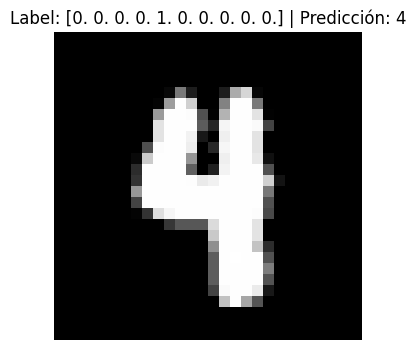

In [37]:
import numpy as np
import matplotlib.pyplot as plt

indexPrediction = 250

# Sacas el vector aplanado (784,)
x_input = x_test[indexPrediction]
y_label = y_test[indexPrediction]

# Para el modelo: necesita (1, 784)
inputPred = np.expand_dims(x_input, axis=0)

# Predicción
y_pred = distilled_student.student.predict(inputPred)
pred_class = np.argmax(y_pred)

print("Label real:", y_label)
print("Predicción:", pred_class)
print("Probabilidades:", y_pred)

# --- Graficar la imagen reconstruida ---
img_2d = x_input.reshape(28, 28)   # <---- ¡IMPORTANTE!

plt.figure(figsize=(4,4))
plt.imshow(img_2d, cmap='gray')
plt.title(f"Label: {y_label} | Predicción: {pred_class}")
plt.axis('off')
plt.show()


In [38]:
model = strip_pruning(distilled_student.student)
model.summary()
model.save('models/CNN/studentModelMnistCNN.h5')

Model: "studentQ_CNN_MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (QConv2D)             (None, 26, 26, 8)         80        
                                                                 
 conv1_act (QActivation)     (None, 26, 26, 8)         0         
                                                                 
 pool1 (MaxPooling2D)        (None, 13, 13, 8)         0         
                                                                 
 conv2 (QConv2D)             (None, 11, 11, 16)        1168      
                                                                 
 conv2_act (QActivation)     (None, 11, 11, 16)        0         
                                                                 
 pool2 (MaxPooling2D)        (None, 5, 5, 16)          0         
                                                                 
 fc1_conv (QConv2D)          (None, 5, 5, 50)     